In [126]:
import sys
import os
import argparse
import logging
import json
import time

import numpy as np
import torch
import pickle
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import BCEWithLogitsLoss, BCELoss ,CrossEntropyLoss
from torch.optim import SGD
from torchvision import models
from torch import nn

from tqdm import tqdm
from tensorboardX import SummaryWriter
from imagedataset import ImageDataset, WSIimageDataset, GradeImageDataset, tumorImageDataset
from clsmodels.models import create_model
from clsmodels import resnet_fpn,senet_fpn
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_recall_curve,average_precision_score
import itertools
import matplotlib.pyplot as plt
from PIL import Image

## tumor

In [3]:
# dataset
slidelist = np.load('data/slide.npy')
testdataset = tumorImageDataset(slidelist,256,224,False)
testdataloader = DataLoader(testdataset,batch_size = 32)
# load model
model = create_model('se_resnext50_32x4d', pretrained=True, num_classes=1, load_backbone_weights=False)
model_file = 'PLC/trainable_0_3000/best_pretrained.pth'
print(f'loading {model_file}...')
model.load_state_dict(torch.load(model_file))
model = nn.DataParallel(model)
model = model.cuda()

loss_fn = BCEWithLogitsLoss().cuda()

loading PLC/trainable_0_3000/best_pretrained.pth...


In [4]:
model.eval()

acclist = []
losslist = []
predlist = []
problist = []

with torch.no_grad():
    progress_bar = tqdm(testdataloader)
    for imgs,label in progress_bar:
        imgs = imgs.float().cuda()
        label = label.float().cuda()

        output = model(imgs)
        output = torch.squeeze(output)
        loss = loss_fn(output,label)

        prob = output.sigmoid()
        pred = (prob>=0.4).type(torch.cuda.FloatTensor)

        acc_data = (pred == label).sum().data * 1.0/32
        loss_data = loss.data

        acclist.append(float(acc_data))
        losslist.append(float(loss_data))
        predlist.extend(pred)
        problist.extend(prob)
        
        progress_bar.set_description(f'loss: {np.mean(losslist):1.4f} acc: {np.mean(acclist):1.4f}')

loss: 1.0036 acc: 0.8042: 100%|██████████| 469/469 [25:17<00:00,  3.23s/it]


In [4]:
pred

tensor([1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 1., 1.], device='cuda:0')

In [5]:
label

tensor([1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 1., 1., 1.], device='cuda:0')

In [6]:
prob

tensor([3.0258e-01, 9.9974e-01, 5.7231e-01, 6.6307e-01, 9.7705e-01, 1.4541e-02,
        4.3898e-01, 5.7720e-01, 1.9674e-01, 6.4987e-01, 7.7483e-01, 2.4860e-01,
        2.5837e-01, 2.5333e-01, 1.8785e-01, 1.1256e-01, 2.8086e-01, 9.3855e-01,
        5.5985e-01, 5.1455e-01, 3.3098e-01, 7.8089e-01, 1.9025e-01, 9.9500e-04],
       device='cuda:0')

In [10]:
labelc = label.cpu()

In [14]:
fpr, tpr, threshold = roc_curve(labelc,prob.cpu())

In [15]:
roc_auc = auc(fpr,tpr)

In [16]:
roc_auc

0.6814814814814815

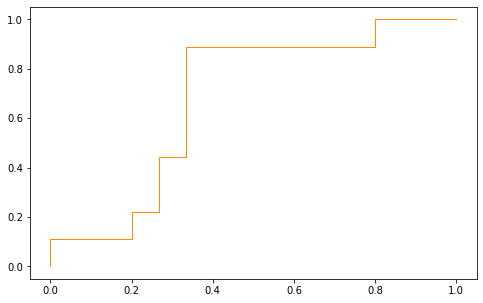

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## nf and shape

In [10]:
slist = np.load('fin.npy')
with open('cftestdata.json','r') as f:
    cf = json.load(f)
slidelist = []
for slide in slist:
    if slide in cf:
        slidelist.append(slide)

In [3]:
slidelist

['201605479-1',
 '201601986-3',
 '201600885-2',
 '201603238-4',
 '201600885-1',
 '201601564-2',
 '201605479-3',
 '201434822-3',
 '201436170-3']

In [30]:
slist = np.load('fin.npy')
with open('sample_cellfeatures1.json','r') as f:
    cf = json.load(f)
with open('cellfeatures.json','r') as f:
    cf_all = json.load(f)
slidelist = []
i = 0
for slide in slist:
    #if slide not in cf and slide in cf_all:
    if slide in cf_all and i < 20:
        slidelist.append(slide)
        i = i + 1

In [117]:
#path = 'temp/results/resnet34_fpn_classifier/re_-1_99_3.pkl'
path = 'temp/results/densenet121/re_ncr_31.pkl'
with open(path,'rb') as  f:
    results = pickle.load(f)

In [74]:
loss_nf = results['loss_nf']
loss_ncr = results['loss_ncr']
loss_shape = results['loss_shape']
loss = results['loss']

loss_nf_val = results['loss_nf_val']
loss_ncr_val = results['loss_ncr_val']
loss_shape_val = results['loss_shape_val']
loss_val = results['loss_val']

acc_nf = results['acc_nf']
acc_ncr = results['acc_ncr']
acc_shape = results['acc_shape']

acc_nf_val = results['acc_nf_val']
acc_ncr_val = results['acc_ncr_val']
acc_shape_val = results['acc_shape_val']


In [154]:
acc_ncr_val

[0.41935483870967744,
 0.4223790322580645,
 0.4405241935483871,
 0.43548387096774194,
 0.4475806451612903,
 0.5332661290322581,
 0.6229838709677419,
 0.6824596774193549,
 0.6935483870967742,
 0.7439516129032258,
 0.7893145161290323,
 0.7953629032258065,
 0.842741935483871,
 0.8639112903225806,
 0.8598790322580645,
 0.8981854838709677,
 0.8840725806451613,
 0.8649193548387096,
 0.8830645161290323,
 0.876008064516129,
 0.8891129032258065,
 0.873991935483871,
 0.8820564516129032,
 0.8598790322580645,
 0.8790322580645161,
 0.8790322580645161,
 0.8598790322580645,
 0.8558467741935484,
 0.842741935483871,
 0.8608870967741935,
 0.8608870967741935,
 0.8800403225806451,
 0.8719758064516129,
 0.8618951612903226,
 0.8225806451612904,
 0.8669354838709677,
 0.8699596774193549,
 0.8245967741935484,
 0.8578629032258065,
 0.7993951612903226,
 0.7651209677419355,
 0.7963709677419355,
 0.8306451612903226,
 0.7469758064516129,
 0.8195564516129032,
 0.8104838709677419,
 0.8266129032258065,
 0.821572580645

In [87]:
np.where(np.array(acc_shape_val)>0.875)

(array([40, 62, 66, 73, 94]),)

In [84]:
np.max(np.array(acc_shape_val))

0.8921370967741935

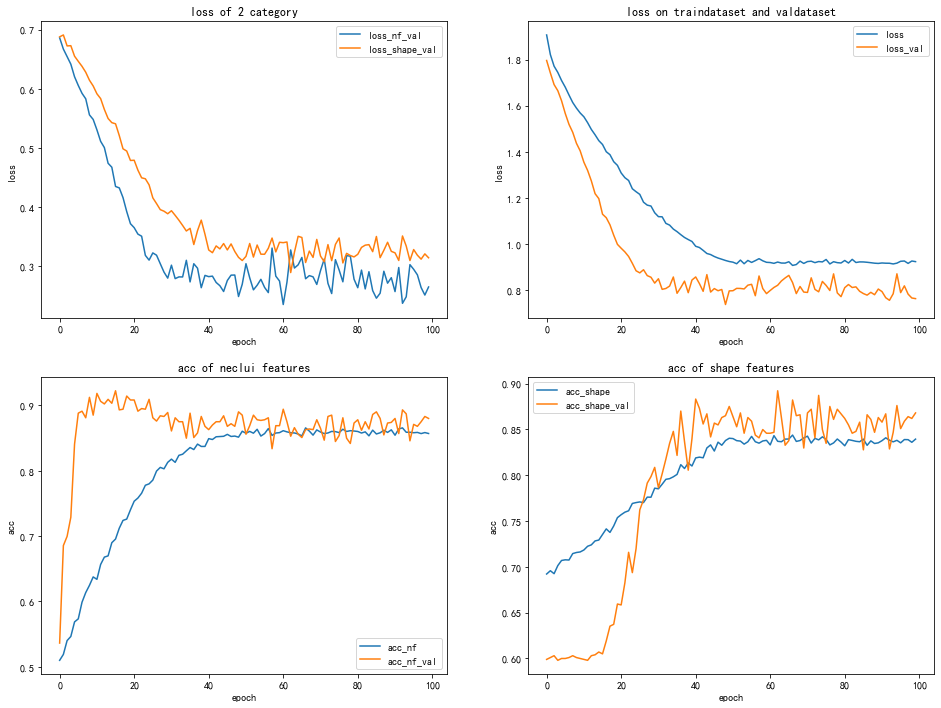

In [4]:
## plot
plt.figure(figsize=(16,12))

# loss nf and shape
plt.subplot(2,2,1)
plt.plot(loss_nf_val)
plt.plot(loss_shape_val)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.legend(['loss_nf','loss_shape','loss_nf_val','loss_shape_val'])
plt.legend(['loss_nf_val','loss_shape_val'])
plt.title('loss of 2 category')
# loss val and train
plt.subplot(2,2,2)
plt.plot(loss)
plt.plot(loss_val)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','loss_val'])
plt.title('loss on traindataset and valdataset')
# acc
plt.subplot(2,2,3)
plt.plot(acc_nf)
plt.plot(acc_nf_val)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['acc_nf','acc_nf_val'])
plt.title('acc of neclui features')

plt.subplot(2,2,4)
plt.plot(acc_shape)
plt.plot(acc_shape_val)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['acc_shape','acc_shape_val'])
plt.title('acc of shape features')
plt.savefig('acc_shape.png')

plt.show()

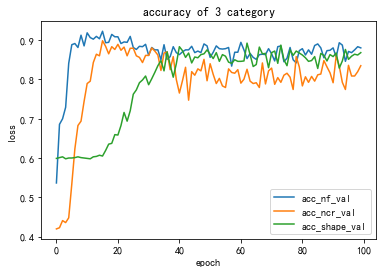

In [5]:
plt.figure()
plt.plot(acc_nf_val)
plt.plot(acc_ncr_val)
plt.plot(acc_shape_val)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.legend(['loss_nf','loss_shape','loss_nf_val','loss_shape_val'])
plt.legend(['acc_nf_val','acc_ncr_val','acc_shape_val'])
plt.title('accuracy of 3 category')
plt.savefig('resnet34fc.png')

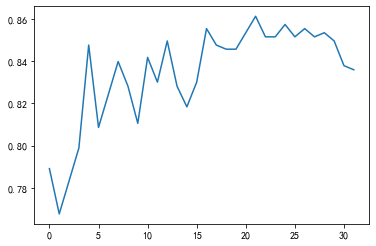

In [120]:
loss_ncr_val = results['acc_val']
plt.figure()
plt.plot(loss_ncr_val)
plt.show()

In [16]:
path = 'temp/results/resnet18/re_ncr_16.pkl'
with open(path,'rb') as  f:
    results = pickle.load(f)

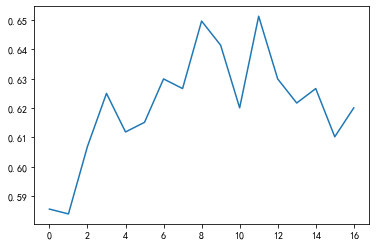

In [17]:
loss_ncr_val = results['acc_val']
#loss_ncr_val = results['acc_shape_val']
plt.figure()
plt.plot(loss_ncr_val)
plt.show()

In [8]:
np.max(acc_shape_val)

0.6214717741935484

## testmodel

In [3]:
slist = np.load('fin.npy')


with open('cftrainnf.json','r') as f:
    cf = json.load(f)
slidelist1 = []
for slide in slist:
    if slide in cf:
        slidelist1.append(slide)
        
i = 0
with open('cellfeatures3.json','r') as f:
    cf = json.load(f)
    slidelist = []
    for slide in slist:
        if slide in cf and slide not in slidelist1:
            i = i + 1 
            slidelist.append(slide)
with open('cftestnf.json','r') as f:
    cf2 = json.load(f)
slidelist2 = []
for slide in slist:
    if slide in cf2:
        slidelist2.append(slide)

In [22]:
slidelist2

['201434013-4', '201603238-2', '201608537-4', '201434822-2', '201603916-3']

In [41]:
slidelist

['201434013-4',
 '201600666-5',
 '201434013-3',
 '201600623-1',
 '201609207-5',
 '201609207-2',
 '201609810-1',
 '201603238-2',
 '201604045-2',
 '201434013-2',
 '201434013-5',
 '201435884-1',
 '201604335-2',
 '201608537-4',
 '201434822-2',
 '201603916-3',
 '201612290-1',
 '201436170-4',
 '201605479-2',
 '201602683-2',
 '201600666-1',
 '201603916-2']

In [63]:
cf2

{'201603916-3': [1, 1, 1, 0, 0, 0],
 '201608537-4': [1, 1, 1, 0, 0, 0],
 '201434822-2': [0, 0, 0, 1, 1, 0],
 '201603238-2': [0, 0, 0, 1, 0, 0],
 '201434013-4': [2, 1, 1, 0, 0, 0]}

In [116]:
index = np.array([1,3,10,20])
slidelistval = np.array(slidelist)[index]
cfval = {}
for i in range(len(slidelisttest)):
    cfval[slidelisttest[i]] = cf[slidelisttest[i]]
cfval

{'201600666-5': [0, 1, 0, 0, 0, 1],
 '201600623-1': [0, 1, 1, 1, 0, 0],
 '201434013-5': [2, 1, 1, 0, 0, 0],
 '201600666-1': [0, 1, 0, 0, 1, 1],
 '201434013-4': [2, 1, 1, 0, 0, 0],
 '201603238-2': [0, 0, 0, 1, 0, 0],
 '201608537-4': [1, 1, 1, 0, 0, 0],
 '201434822-2': [0, 0, 0, 1, 1, 0],
 '201603916-3': [1, 1, 1, 0, 0, 0]}

In [71]:
np.unique(slidelisttest)

array(['201434013-4', '201434013-5', '201434822-2', '201600623-1',
       '201600666-1', '201600666-5', '201603238-2', '201603916-3',
       '201608537-4'], dtype='<U11')

In [92]:
slidelisttest = slidelistval.tolist() + slidelist2

In [135]:
model = create_model('resnet18',pretrained = True,num_classes=2)
#model = resnet_fpn.resnet34_fpn_classifier(num_classes=[2,2,2],pretrained = True)
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load('temp/checkpoints/bestmodel/resnet18_8_ncr_1_best.pth.tar'))

#model = torch.nn.DataParallel(model).cuda()

#retinanet = torch.nn.DataParallel(retinanet).cuda()
testdataset = ImageDataset(slide_list = slidelisttest,
                            img_size = 512,
                            level = 1,
                            is_training = True)
testdataloader = DataLoader(testdataset,
                            batch_size = 32,
                            shuffle = True,
                            drop_last = True)
loss_fn = BCEWithLogitsLoss().cuda()

create_pretrained_resnet 18
creating resnet18, pretrained: True


In [136]:
model.eval()
#model.module.freeze_bn()
ALPHA = 0.5
print('Num training images: {}'.format(len(testdataset)))
with torch.no_grad():
    model.eval()
    epoch_loss_val = []
    loss_val = []
    acc_val = []
    preds = []
    trues = []
    probs = []

    progress_bar = tqdm(enumerate(testdataloader),total = len(testdataloader))
    for iter_num,data in progress_bar:
        img,label1,label2,label3 = data
        img = img.cuda().float()
        label = label1.cuda().float()
        output = model(img)

        output = torch.squeeze(output)
        #output2 = torch.squeeze(output2)
        
        prob = output.sigmoid()
        
        loss = loss_fn(output,label)
        #loss_shape = loss_fn(output2,label_shape)

        #loss = loss_nf + ALPHA*loss_shape

        pred = output.argmax(axis=1)
        #pred_shape = output2.argmax(axis=1)

        #print(pred_shape)
        #print(label_shape.argmax(axis=1))

        acc = (pred == label.argmax(axis=1)).sum().data * 1.0/32
        #acc_shape = (pred_shape == label_shape.argmax(axis=1)).sum().data * 1.0/32

        loss_val.append(float(loss))
        #loss_cls2_val.append(float(loss_shape))
        #epoch_loss_val.append(float(loss))
        acc_val.append(float(acc))
        #acc_cls2_val.append(float(acc_shape))
        preds.extend(np.array(pred.cpu()).tolist())
        #pred2.extend(np.array(pred_shape.cpu()).tolist())
        trues.extend(np.array(label.argmax(axis=1).cpu()).tolist())
        #true2.extend(np.array(label_shape.argmax(axis=1).cpu()).tolist())
        probs.extend(np.array(prob[:,1].cpu()).tolist())


        progress_bar.set_description(
            f'cls_nf: {np.mean(loss_val):1.4f} acc_nf: {np.mean(acc_val):1.4f}')


  0%|          | 0/56 [00:00<?, ?it/s]

Num training images: 1800


cls_nf: 0.5667 acc_nf: 0.7522: 100%|██████████| 56/56 [00:41<00:00,  1.36it/s]


In [124]:
# 单特征结果
cm = confusion_matrix(trues,preds,labels = [1,0])
TP = cm[0,0]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[1,1]

precision = TP/(TP+FP)
recall = TP/(TP+FN)
specifity = TN/(TN+FP)
accuracy = (TP+TN)/(TP+FP+FN+TN)
f1_score = 2*precision*recall/(precision+recall)

print(f'pre:{precision:.4f},rec:{recall:.4f},spe:{specifity:.4f},acc:{accuracy:.4f},f1-score:{f1_score:.4f}')

pre:0.9745,rec:0.7948,spe:0.9271,acc:0.8242,f1-score:0.8755


In [131]:
## roc曲线
dense_nf = {}
dense_nf['label'] = trues
dense_nf['prob'] = probs

In [125]:
dense_ncr = {}
dense_ncr['label'] = trues
dense_ncr['prob'] = probs

In [19]:
dense_shape = {}
dense_shape['label'] = trues
dense_shape['prob'] = probs

In [134]:
bl_nf = {}
bl_nf['label'] = trues
bl_nf['prob'] = probs

In [137]:
bl_ncr = {}
bl_ncr['label'] = trues
bl_ncr['prob'] = probs

In [15]:
bl_shape = {}
bl_shape['label'] = trues
bl_shape['prob'] = probs

In [185]:
## 多特征结果
#model = create_model('densenet121',pretrained = True,num_classes=2)
#model = resnet_fpn.resnet34_fc_classifier(num_classes=[2,2,2],pretrained = True)
model = senet_fpn.se_resnet50_fpn_classifier(num_classes=[2,2,2])
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load('temp/checkpoints/bestmodel/se_resnet50_fpn_classifier_89_3_best.pth.tar'))

#model = torch.nn.DataParallel(model).cuda()

#retinanet = torch.nn.DataParallel(retinanet).cuda()
testdataset = ImageDataset(slide_list = slidelist2,
                            img_size = 512,
                            level = 1,
                            is_training = True)
testdataloader = DataLoader(testdataset,
                            batch_size = 32,
                            shuffle = True,
                            drop_last = True)
loss_fn = BCEWithLogitsLoss().cuda()

In [186]:
model.eval()
#model.module.freeze_bn()
ALPHA = 0.5
print('Num training images: {}'.format(len(testdataset)))
with torch.no_grad():
    model.eval()
    epoch_loss_val = []
    loss_cls1_val = []
    loss_cls2_val = []
    acc_cls1_val = []
    acc_cls2_val = []
    acc_cls3_val = []
    pred1 = []
    pred2 = []
    pred3 = []
    true1 = []
    true2 = []
    true3 = []
    probs1 = []
    probs2 = []
    probs3 = []

    progress_bar = tqdm(enumerate(testdataloader),total = len(testdataloader))
    for iter_num,data in progress_bar:
        img, label_nf,label_ncr,label_shape = data
        img = img.cuda().float()
        label_nf = label_nf.cuda().float()
        label_ncr = label_ncr.cuda().float()
        label_shape = label_shape.cuda().float()
        output1,output2,output3 = model(img)

        output1 = torch.squeeze(output1)
        output2 = torch.squeeze(output2)
        output3 = torch.squeeze(output3)
        
        prob1 = output1.sigmoid()
        prob2 = output2.sigmoid()
        prob3 = output3.sigmoid()
        
        loss_nf = loss_fn(output1,label_nf)
        #loss_shape = loss_fn(output2,label_shape)

        #loss = loss_nf + ALPHA*loss_shape

        pred_nf = output1.argmax(axis=1)
        pred_ncr = output2.argmax(axis=1)
        pred_shape = output3.argmax(axis=1)

        #print(pred_shape)
        #print(label_shape.argmax(axis=1))

        acc_nf = (pred_nf == label_nf.argmax(axis=1)).sum().data * 1.0/32
        acc_ncr = (pred_ncr == label_ncr.argmax(axis=1)).sum().data * 1.0/32
        acc_shape = (pred_shape == label_shape.argmax(axis=1)).sum().data * 1.0/32

        loss_cls1_val.append(float(loss_nf))
        #loss_cls2_val.append(float(loss_shape))
        #epoch_loss_val.append(float(loss))
        acc_cls1_val.append(float(acc_nf))
        acc_cls2_val.append(float(acc_ncr))
        acc_cls3_val.append(float(acc_shape))
        pred1.extend(np.array(pred_nf.cpu()).tolist())
        pred2.extend(np.array(pred_ncr.cpu()).tolist())
        pred3.extend(np.array(pred_shape.cpu()).tolist())
        true1.extend(np.array(label_nf.argmax(axis=1).cpu()).tolist())
        true2.extend(np.array(label_ncr.argmax(axis=1).cpu()).tolist())
        true3.extend(np.array(label_shape.argmax(axis=1).cpu()).tolist())
        probs1.extend(np.array(prob1[:,1].cpu()).tolist())
        probs2.extend(np.array(prob2[:,1].cpu()).tolist())
        probs3.extend(np.array(prob3[:,1].cpu()).tolist())


        progress_bar.set_description(
            f'cls_nf: {np.mean(loss_cls1_val):1.4f} acc_nf: {np.mean(acc_cls1_val):1.4f} acc_ncr: {np.mean(acc_cls2_val):1.4f} acc_shape: {np.mean(acc_cls3_val):1.4f}')


  0%|          | 0/31 [00:00<?, ?it/s]

Num training images: 1000


cls_nf: 0.3339 acc_nf: 0.8851 acc_ncr: 0.8256 acc_shape: 0.5978: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


In [184]:
cm = confusion_matrix(true2,pred2,labels = [1,0])
TP = cm[0,0]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[1,1]

precision = TP/(TP+FP)
recall = TP/(TP+FN)
specifity = TN/(TN+FP)
accuracy = (TP+TN)/(TP+FP+FN+TN)
f1_score = 2*precision*recall/(precision+recall)

print(f'pre:{precision:.4f},rec:{recall:.4f},spe:{specifity:.4f},acc:{accuracy:.4f},f1-score:{f1_score:.4f}')

pre:0.9424,rec:0.7429,spe:0.9320,acc:0.8185,f1-score:0.8308


In [30]:
np.sum(pred1)/len(pred1)

0.5020161290322581

In [184]:
resfpn_nf = {}
resfpn_nf['label'] = true1
resfpn_nf['prob'] = probs1
# resfpn_ncr = {}
# resfpn_ncr['label'] = true2
# resfpn_ncr['prob'] = prob1
# resfpn_shape = {}
# resfpn_shape['label'] = true3
# resfpn_shape['prob'] = prob1

In [166]:
resfc_nf = {}
resfc_nf['label'] = true1
resfc_nf['prob'] = probs1
resfc_ncr = {}
resfc_ncr['label'] = true2
resfc_ncr['prob'] = probs2
resfc_shape = {}
resfc_shape['label'] = true3
resfc_shape['prob'] = probs3

In [187]:
seresfpn_nf = {}
seresfpn_nf['label'] = true1
seresfpn_nf['prob'] = probs1
seresfpn_ncr = {}
seresfpn_ncr['label'] = true2
seresfpn_ncr['prob'] = probs3
seresfpn_shape = {}
seresfpn_shape['label'] = true3
seresfpn_shape['prob'] = probs3

In [176]:
len(resfc_nf['prob'])

32

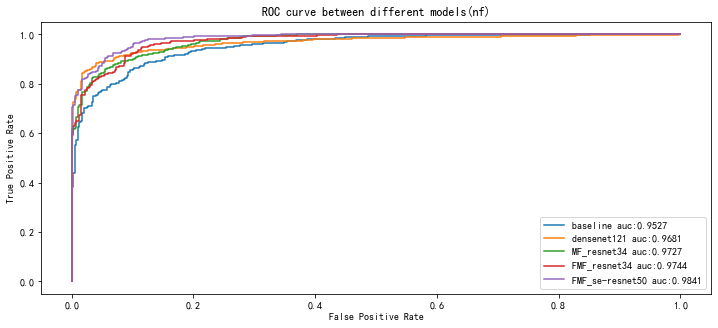

In [201]:
### ROC
plt.figure(figsize=(12,5))
fprbl, tprbl, thresholdbl = roc_curve(bl_nf['label'],bl_nf['prob'])
roc_aucbl = auc(fprbl,tprbl)
plt.plot(fprbl, tprbl)

fprde, tprde, thresholdde = roc_curve(dense_nf['label'],dense_nf['prob'])
roc_aucde = auc(fprde,tprde)
plt.plot(fprde, tprde)

fprfc, tprfc, thresholdfc = roc_curve(resfc_nf['label'],resfc_nf['prob'])
roc_aucfc = auc(fprfc,tprfc)
plt.plot(fprfc, tprfc)

fprfpn, tprfpn, thresholdfpn = roc_curve(resfpn_nf['label'],resfpn_nf['prob'])
roc_aucfpn = auc(fprfpn,tprfpn)
plt.plot(fprfpn, tprfpn)

fprsefpn, tprsefpn, thresholdsefpn = roc_curve(seresfpn_nf['label'],seresfpn_nf['prob'])
roc_aucsefpn = auc(fprsefpn,tprsefpn)
plt.plot(fprsefpn, tprsefpn)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([f'baseline auc:{roc_aucbl:.4f}',f'densenet121 auc:{roc_aucde:.4f}',f'MF_resnet34 auc:{roc_aucfc:.4f}',f'FMF_resnet34 auc:{roc_aucfpn:.4f}',f'FMF_se-resnet50 auc:{roc_aucsefpn:.4f}'])
plt.title('ROC curve between different models(nf)')
plt.savefig('roc_curve_nf.png')
plt.show()

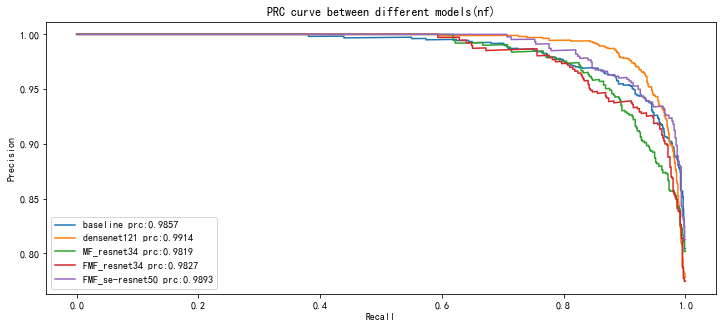

In [204]:
### PRC
plt.figure(figsize=(12,5))
prebl, recbl, thresholdbl = precision_recall_curve(bl_nf['label'],bl_nf['prob'])
roc_aucbl = average_precision_score(bl_nf['label'],bl_nf['prob'])
plt.plot(recbl, prebl)

prede, recde, thresholdbl = precision_recall_curve(dense_nf['label'],dense_nf['prob'])
roc_aucde = average_precision_score(dense_nf['label'],dense_nf['prob'])
plt.plot(recde, prede)

prefc, recfc, thresholdbl = precision_recall_curve(resfc_nf['label'],resfc_nf['prob'])
roc_aucfc = average_precision_score(resfc_nf['label'],resfc_nf['prob'])
plt.plot(recfc, prefc)

prefpn, recfpn, thresholdbl = precision_recall_curve(resfpn_nf['label'],resfpn_nf['prob'])
roc_aucfpn = average_precision_score(resfpn_nf['label'],resfpn_nf['prob'])
plt.plot(recfpn, prefpn)

presefpn, recsefpn, thresholdfpn = precision_recall_curve(seresfpn_nf['label'],seresfpn_nf['prob'])
roc_aucsefpn = average_precision_score(seresfpn_nf['label'],seresfpn_nf['prob'])
plt.plot(recsefpn, presefpn)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend([f'baseline prc:{roc_aucbl:.4f}',f'densenet121 prc:{roc_aucde:.4f}',f'MF_resnet34 prc:{roc_aucfc:.4f}',f'FMF_resnet34 prc:{roc_aucfpn:.4f}',f'FMF_se-resnet50 prc:{roc_aucsefpn:.4f}'])
plt.title('PRC curve between different models(nf)')
plt.savefig('prc_curve_nf.png')
plt.show()

In [190]:
seresfpn_ncr['prob'] = 1-np.array(seresfpn_ncr['prob'])

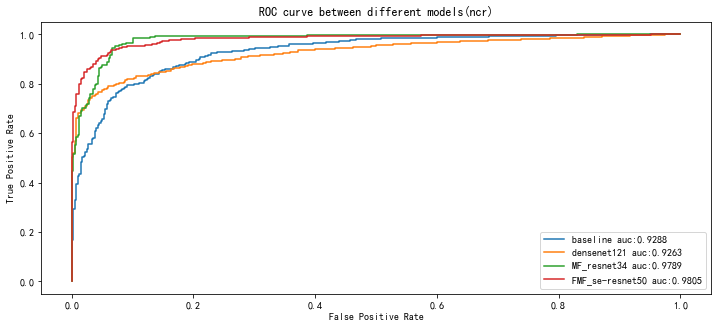

In [191]:
### ROC
plt.figure(figsize=(12,5))
fprbl, tprbl, thresholdbl = roc_curve(bl_ncr['label'],bl_ncr['prob'])
roc_aucbl = auc(fprbl,tprbl)
plt.plot(fprbl, tprbl)

fprde, tprde, thresholdde = roc_curve(dense_ncr['label'],dense_ncr['prob'])
roc_aucde = auc(fprde,tprde)
plt.plot(fprde, tprde)

fprfc, tprfc, thresholdfc = roc_curve(resfc_ncr['label'],resfc_ncr['prob'])
roc_aucfc = auc(fprfc,tprfc)
plt.plot(fprfc, tprfc)

# fprfpn, tprfpn, thresholdfpn = roc_curve(resfpn_nf['label'],resfpn_nf['prob'])
# roc_aucfpn = auc(fprfpn,tprfpn)
# plt.plot(fprfpn, tprfpn)

fprsefpn, tprsefpn, thresholdsefpn = roc_curve(seresfpn_ncr['label'],seresfpn_ncr['prob'])
roc_aucsefpn = auc(fprsefpn,tprsefpn)
plt.plot(fprsefpn, tprsefpn)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([f'baseline auc:{roc_aucbl:.4f}',f'densenet121 auc:{roc_aucde:.4f}',f'MF_resnet34 auc:{roc_aucfc:.4f}',f'FMF_se-resnet50 auc:{roc_aucsefpn:.4f}'])
plt.title('ROC curve between different models(ncr)')
#plt.savefig('roc_curve_ncr.png')
plt.show()

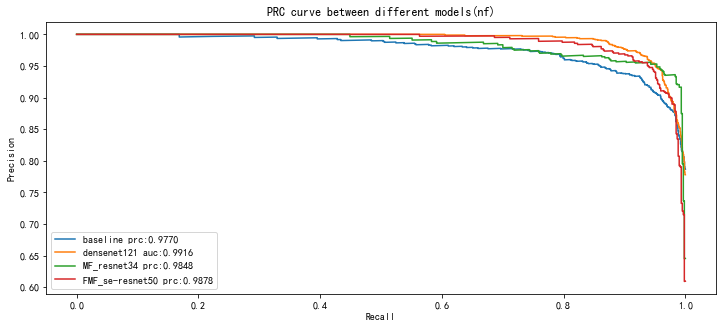

In [192]:
### PRC
plt.figure(figsize=(12,5))
prebl, recbl, thresholdbl = precision_recall_curve(bl_ncr['label'],bl_ncr['prob'])
roc_aucbl = average_precision_score(bl_ncr['label'],bl_ncr['prob'])
plt.plot(recbl, prebl)

prede, recde, thresholdbl = precision_recall_curve(dense_nf['label'],dense_nf['prob'])
roc_aucde = average_precision_score(dense_nf['label'],dense_nf['prob'])
plt.plot(recde, prede)

prefc, recfc, thresholdbl = precision_recall_curve(resfc_ncr['label'],resfc_ncr['prob'])
roc_aucfc = average_precision_score(resfc_ncr['label'],resfc_ncr['prob'])
plt.plot(recfc, prefc)

# prefpn, recfpn, thresholdbl = precision_recall_curve(resfpn_nf['label'],resfpn_nf['prob'])
# roc_aucfpn = average_precision_score(resfpn_nf['label'],resfpn_nf['prob'])
# plt.plot(recfpn, prefpn)

presefpn, recsefpn, thresholdfpn = precision_recall_curve(seresfpn_ncr['label'],seresfpn_ncr['prob'])
roc_aucsefpn = average_precision_score(seresfpn_ncr['label'],seresfpn_ncr['prob'])
plt.plot(recsefpn, presefpn)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend([f'baseline prc:{roc_aucbl:.4f}',f'densenet121 auc:{roc_aucde:.4f}',f'MF_resnet34 prc:{roc_aucfc:.4f}',f'FMF_se-resnet50 prc:{roc_aucsefpn:.4f}'])
plt.title('PRC curve between different models(nf)')
plt.savefig('prc_curve_ncr.png')
plt.show()

In [174]:
presefpn

array([0.65460526, 0.65422613, 0.65494505, 0.65566557, 0.65638767,
       0.65711136, 0.65783664, 0.65856354, 0.65929204, 0.66002215,
       0.66075388, 0.66148724, 0.66222222, 0.66295884, 0.6636971 ,
       0.66443701, 0.66517857, 0.66592179, 0.66666667, 0.66741321,
       0.66816143, 0.66891134, 0.66966292, 0.6704162 , 0.67117117,
       0.67192785, 0.67268623, 0.67344633, 0.67420814, 0.67497169,
       0.67573696, 0.67650397, 0.67727273, 0.67804323, 0.67881549,
       0.67958951, 0.6803653 , 0.68114286, 0.6819222 , 0.68270332,
       0.68348624, 0.68427095, 0.68505747, 0.6858458 , 0.68663594,
       0.68742791, 0.68822171, 0.68901734, 0.68981481, 0.69061414,
       0.69141531, 0.69221835, 0.69302326, 0.69383003, 0.69463869,
       0.69544924, 0.69626168, 0.69707602, 0.69789227, 0.69871043,
       0.69953052, 0.70035253, 0.70117647, 0.70200236, 0.70283019,
       0.70365998, 0.70449173, 0.70532544, 0.70616114, 0.70699881,
       0.70783848, 0.70868014, 0.70952381, 0.71036949, 0.71121

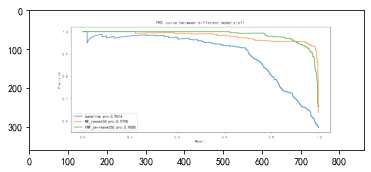

In [128]:
img = Image.open('prc_curve_ncr.png')
plt.figure()
plt.imshow(img)
plt.show()

In [10]:
label1 = np.array(true1)
index = np.where(np.array(true1)<2)[0]
label1 = label1[index]
probnp1 = np.array(probs1)
probnp1= probnp1[index]

In [11]:
label2 = np.array(true2)
probnp2 = np.array(probs2)
cm2 = confusion_matrix(label2,np.array(pred2))

label3 = np.array(true3)
probnp3 = np.array(probs3)
cm3 = confusion_matrix(label3,np.array(pred3))

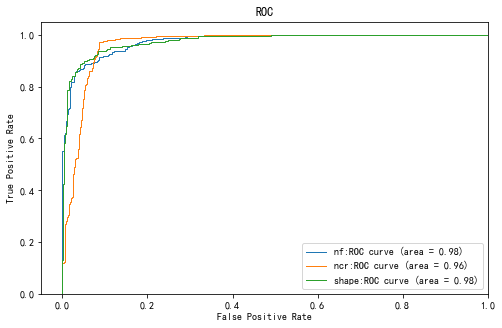

In [14]:
fpr1, tpr1, threshold1 = roc_curve(label1,probnp1)
roc_auc1 = auc(fpr1,tpr1)
plt.figure(figsize=(8, 5))
plt.plot(fpr1, tpr1, 
        lw=1, label='nf:ROC curve (area = %0.2f)' % roc_auc1)

fpr2, tpr2, threshold2 = roc_curve(label2,probnp2)
roc_auc2 = auc(fpr2,tpr2)

plt.plot(fpr2, tpr2, 
        lw=1, label='ncr:ROC curve (area = %0.2f)' % roc_auc2)

fpr3, tpr3, threshold3 = roc_curve(label3,probnp3)
roc_auc3 = auc(fpr3,tpr3)

plt.plot(fpr3, tpr3, 
        lw=1, label='shape:ROC curve (area = %0.2f)' % roc_auc3)

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('resnet18fpn_roc.png')
plt.show()

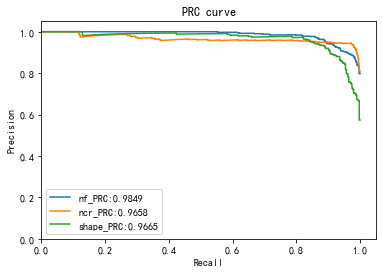

In [25]:
## prc curve
pre1,rec1,_ = precision_recall_curve(label1,probnp1)
ap1 = average_precision_score(label1,probnp1)

pre2,rec2,_ = precision_recall_curve(label2,probnp2)
ap2 = average_precision_score(label2,probnp2)

pre3,rec3,_ = precision_recall_curve(label3,probnp3)
ap3 = average_precision_score(label3,probnp3)

plt.figure()
plt.plot(rec1,pre1)
#plt.step(rec1,pre1,where='post',alpha=0.2)
#plt.fill_between(rec1,pre1,step='post',alpha=0.2)

plt.plot(rec2,pre2)
#plt.fill_between(rec2,pre2,step='post',alpha=0.2)

plt.plot(rec3,pre3)
#plt.fill_between(rec3,pre3,step='post',alpha=0.2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0,1.05])
plt.ylim([0.0,1.05])
plt.title('PRC curve')
plt.legend([f'nf_PRC:{ap1:.4f}',f'ncr_PRC:{ap2:.4f}',f'shape_PRC:{ap3:.4f}'])
plt.savefig('res31fpnprc.png')
plt.show()

In [20]:
## confusion matrix
def plot_confusion_matrix(cm,labels_name,title='confusion matrix'):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2f}'.format(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if float(num) > thresh else "black")
    
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

In [7]:
cm = confusion_matrix(np.array(true1),np.array(pred1))

In [8]:
import matplotlib
print(matplotlib.matplotlib_fname())

/home/yinxiaoxu/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc


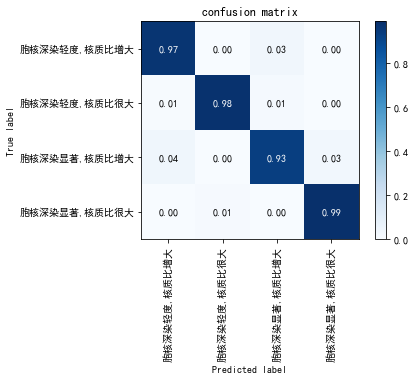

In [21]:
labels_name = ['胞核深染轻度,核质比增大','胞核深染轻度,核质比很大','胞核深染显著,核质比增大','胞核深染显著,核质比很大']
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plot_confusion_matrix(cm,labels_name)
# plt.savefig('temp/results/images/cm_nf.png')
plt.show()